# Модель обработки тревог самокатов v3

## Загрузка данных из бд

In [119]:
import sys
from pathlib import Path
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))
    
from config import DB_URI
from sqlalchemy import create_engine, text
import pandas as pd
from tqdm import tqdm


engine = create_engine(DB_URI)

with engine.connect() as conn:
    total = conn.execute(text("SELECT COUNT(*) FROM incidents")).scalar()

batch_size = 5000
offset = 0
rows = []

with engine.connect() as conn, tqdm(total=total, desc="Загрузка данных", unit="строк") as pbar:
    while True:
        query = f"""
            SELECT 
                mf.*, 
                i.business_status, 
                CASE 
                    WHEN i.business_status IS NULL THEN 0
                    WHEN i.business_status = 'Investigation' THEN 1
                    ELSE NULL
                END AS business_status_numeric,
                i.created_at, 
                i.identifier,
                mpf.is_weak_motion, mpf.is_slow_progress, mpf.is_circular_motion, mpf.is_no_motion,
                rf.looks_like_rent, rf.moved_without_rent, rf.moved_immediately_after_rent,
                rf.returned_to_access_5min, rf.had_rent_last_2h, rf.end_is_start,
                tf.is_night_alarm, tf.alarm_delay_seconds, tf.alarm_hour,
                zf.was_in_tech_zone_before_alarm, zf.was_in_restricted_zone_before_alarm,
                gqf.valid_coord_ratio, gqf.average_satellites, gqf.average_rssi, 
                gqf.unstable_gps_jumps, gqf.detected_jumps,
                oc.*
            FROM movement_features mf
            LEFT JOIN incidents i ON mf.incident_id = i.id
            LEFT JOIN motion_pattern_features mpf ON mf.incident_id = mpf.incident_id
            LEFT JOIN rental_features rf ON mf.incident_id = rf.incident_id
            LEFT JOIN time_features tf ON mf.incident_id = tf.incident_id
            LEFT JOIN zone_features zf ON mf.incident_id = zf.incident_id
            LEFT JOIN gps_quality_features gqf ON mf.incident_id = gqf.incident_id
            LEFT JOIN operator_comments oc ON mf.incident_id = oc.incident_id
            ORDER BY mf.id
            OFFSET {offset} LIMIT {batch_size}
        """

        batch = pd.read_sql_query(text(query), conn)

        if batch.empty:
            break

        rows.append(batch)
        offset += batch_size
        pbar.update(len(batch))

df = pd.concat(rows, ignore_index=True)


Загрузка данных: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 244628/245750 [02:14<00:00, 1819.66строк/s]
/tmp/ipykernel_359537/504930293.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(rows, ignore_index=True)


## EDA + data preprocessing

In [142]:
nan_summary = df.isnull().sum().to_frame(name='missing_count')
nan_summary['missing_percent'] = (nan_summary['missing_count'] / len(df)) * 100

nan_summary = nan_summary.sort_values(by='missing_count', ascending=False)

print(nan_summary)

                                     missing_count  missing_percent
max_speed_kmh                                    0              0.0
detected_jumps                                   0              0.0
alarm_delay_seconds                              0              0.0
alarm_hour                                       0              0.0
was_in_tech_zone_before_alarm                    0              0.0
was_in_restricted_zone_before_alarm              0              0.0
valid_coord_ratio                                0              0.0
average_satellites                               0              0.0
average_rssi                                     0              0.0
unstable_gps_jumps                               0              0.0
flag                                             0              0.0
end_is_start                                     0              0.0
low_battery                                      0              0.0
needs_repair                                    

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../data/preprocessed_dataset_v3.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244627 entries, 0 to 244626
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           244627 non-null  int64  
 1   max_speed_kmh                        244627 non-null  float64
 2   mean_speed_kmh                       244627 non-null  float64
 3   median_speed_kmh                     244627 non-null  float64
 4   is_too_fast_speed                    244627 non-null  int64  
 5   is_too_fast_trip                     244627 non-null  int64  
 6   is_only_linear_segments              244627 non-null  int64  
 7   is_zigzag                            244627 non-null  int64  
 8   is_back_and_forth                    244627 non-null  int64  
 9   is_highly_linear                     244627 non-null  int64  
 10  has_long_stop                        244627 non-null  int64  
 11  total_distanc

In [6]:
df.business_status.value_counts()

business_status
0    232723
1     11904
Name: count, dtype: int64

In [121]:
df = df.dropna(subset=['id'])

In [131]:
df.dtypes

max_speed_kmh                          float64
mean_speed_kmh                         float64
median_speed_kmh                       float64
is_too_fast_speed                        int64
is_too_fast_trip                         int64
is_only_linear_segments                  int64
is_zigzag                                int64
is_back_and_forth                        int64
is_highly_linear                         int64
has_long_stop                            int64
total_distance                         float64
track_point_count                        int64
business_status                          int64
is_weak_motion                           int64
is_slow_progress                         int64
is_circular_motion                       int64
is_no_motion                             int64
looks_like_rent                          int64
moved_without_rent                       int64
moved_immediately_after_rent             int64
returned_to_access_5min                  int64
had_rent_last

In [125]:
incident_ids = df['incident_id']

In [126]:
df = df.drop(columns=['id', 'incident_id', 'gps_jumps_count', 'comment', 'created_at'])

In [ ]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

binary_nan_cols = [
    'is_zigzag',
    'is_circular_motion',
    'was_in_tech_zone_before_alarm',
    'was_in_restricted_zone_before_alarm',
    'moved_immediately_after_rent',
    'had_rent_last_2h',
    'returned_to_access_5min',
    'is_back_and_forth',
    'flag', 'low_battery', 'needs_repair', 'gps_error',
    'outside_zone', 'alarm_movement', 'returned_to_access',
    'rent_blocked', 'awaiting_service', 'no_connection'
]

for col in binary_nan_cols:
    df[col] = df[col].map({'True': 1, 'False': 0})
    df[col] = df[col].fillna(False).astype(int)

df['alarm_delay_seconds'] = df['alarm_delay_seconds'].fillna(-1)

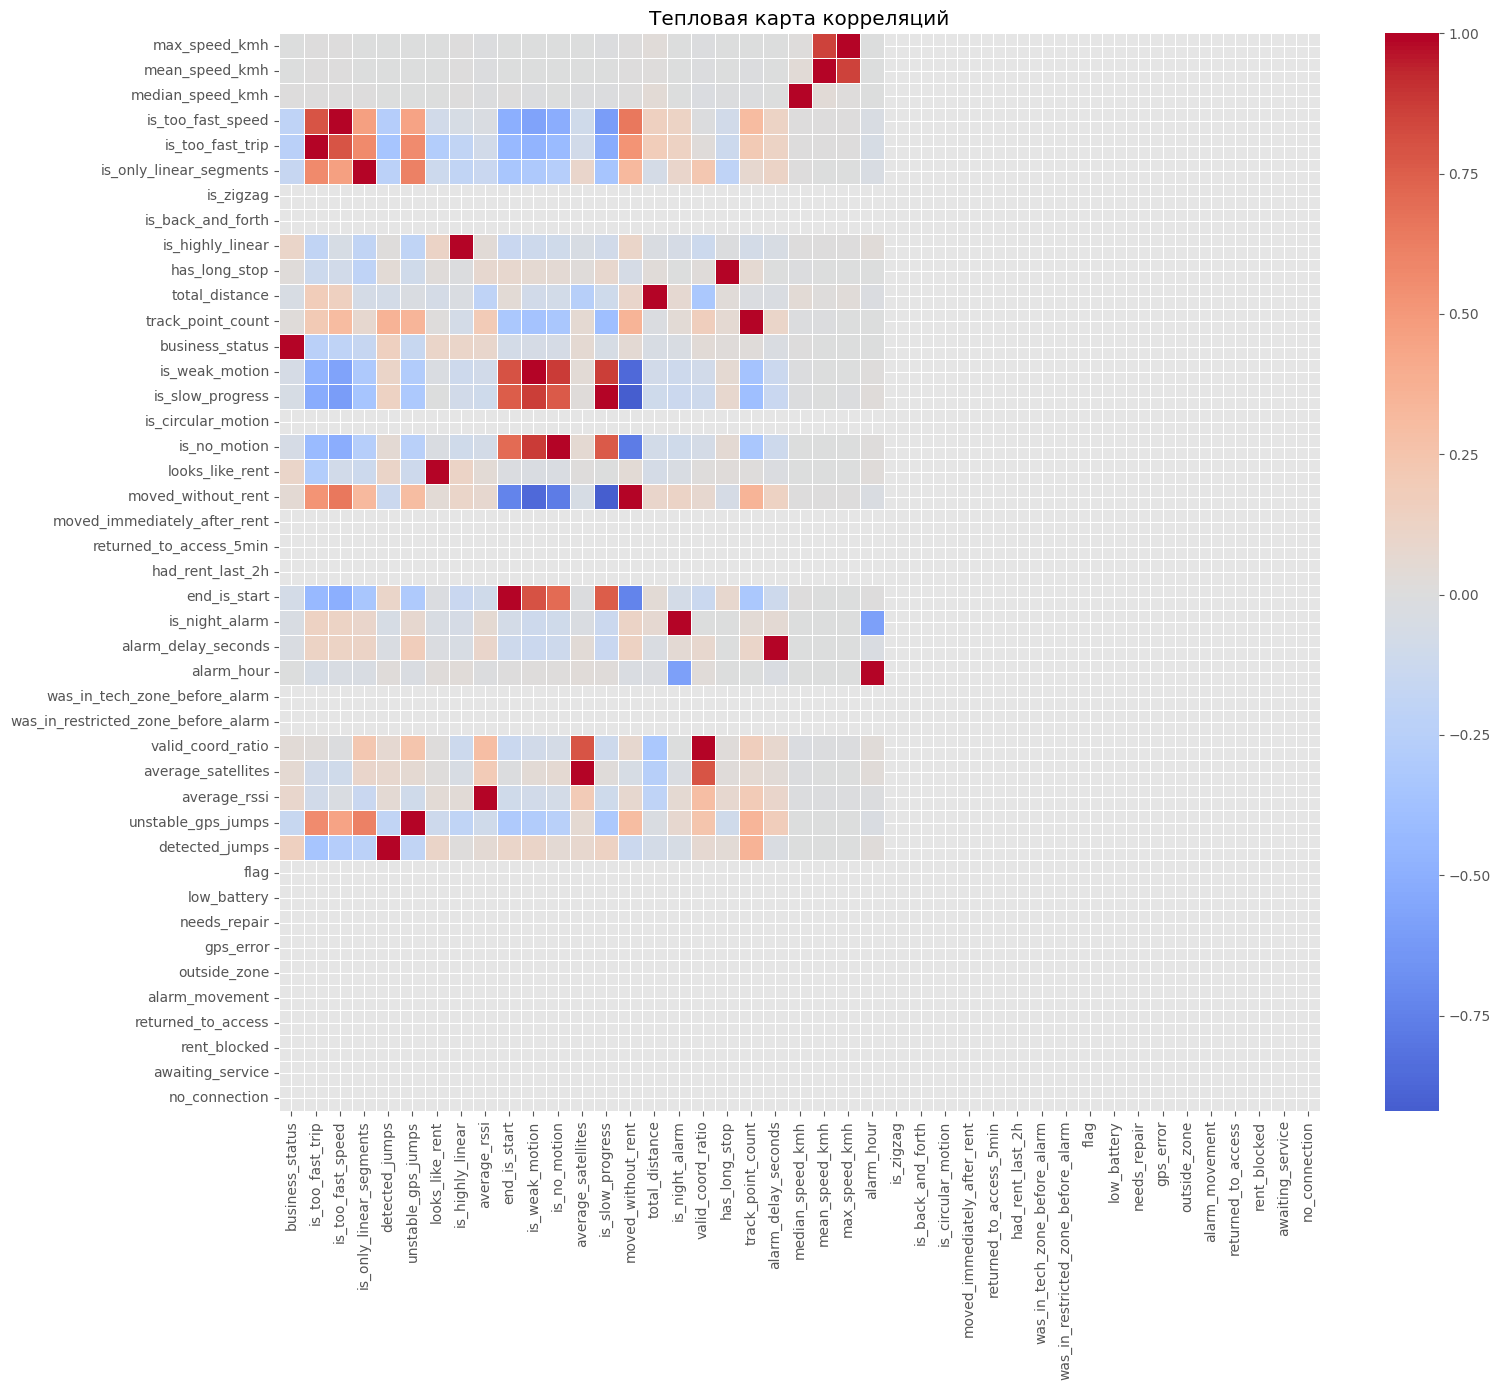

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

corr_matrix = df.corr()

if "business_status" in corr_matrix.columns:
    corr_matrix = corr_matrix[corr_matrix["business_status"].abs().sort_values(ascending=False).index]

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Тепловая карта корреляций")
plt.tight_layout()
plt.show()


In [ ]:
df['alarm_hour'] = df['alarm_hour'].str.extract(r'(\d+)').astype(int)

df['business_status'] = df['business_status'].fillna('0')
df['business_status'] = df['business_status'].replace('Investigation', '1')
df['business_status'] = df['business_status'].astype(int)

In [217]:
df.to_csv('../data/preprocessed_dataset_v3.csv')

## Model train

In [143]:
y = df['business_status']
X = df.drop(columns=['business_status'])

In [156]:
import optuna
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, recall_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import time


In [194]:
results = []

def objective(trial):
    trial_start = time.time()
    model_type = trial.suggest_categorical("model_type", ["xgb"])

    if model_type == "xgb":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 20),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
            "use_label_encoder": False,
            "eval_metric": "logloss"
        }
        base_model = XGBClassifier(**params)
        model = make_pipeline(SimpleImputer(strategy="mean"), base_model)

    else:
        raise ValueError("Unknown model type")

    # === Cross-Validation ===
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, recalls = [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        if time.time() - trial_start > 300:
            raise optuna.exceptions.TrialPruned()

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        f1_scores.append(f1_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recalls)
    score = 0.6 * mean_f1 + 0.4 * mean_recall

    result = {
        "trial_number": trial.number,
        "model": model_type,
        **params,
        "f1": mean_f1,
        "recall": mean_recall,
        "score": score
    }

    results.append(result)
    pd.DataFrame(results).to_csv("../data/optuna_live_results.csv", index=False)

    return score


In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def log_callback(study, trial):
    print(f"[Trial {trial.number}] Done. Value: {trial.value:.5f} | Params: {trial.params}")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=3600, show_progress_bar=True, callbacks=[log_callback])


/tmp/ipykernel_359537/3119084872.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opt_viz.plot_optimization_history(study)


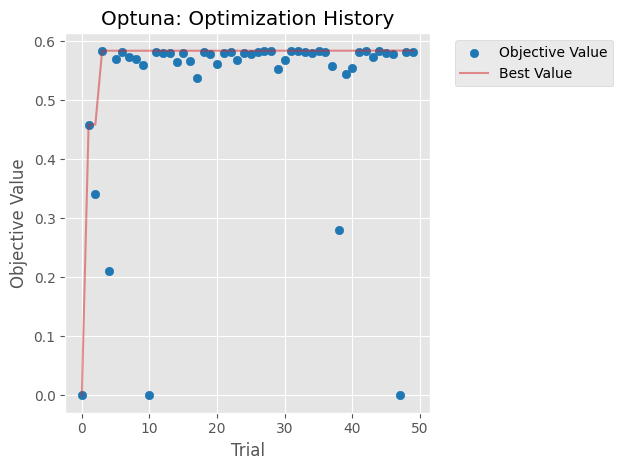

/tmp/ipykernel_359537/3119084872.py:11: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opt_viz.plot_param_importances(study)


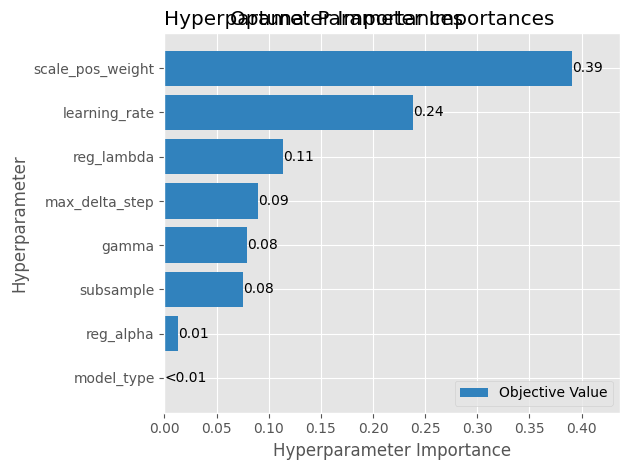

Лучшая модель:
{'model_type': 'xgb', 'learning_rate': 0.1657639455187537, 'subsample': 0.819098824488613, 'gamma': 4.184987276990122, 'reg_alpha': 4.694779639068039, 'reg_lambda': 8.244942547491538, 'scale_pos_weight': 16, 'max_delta_step': 5}

Оптимальный threshold: 0.818 (F1 = 0.504)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     46545
           1       0.44      0.58      0.50      2381

    accuracy                           0.94     48926
   macro avg       0.71      0.77      0.74     48926
weighted avg       0.95      0.94      0.95     48926

ROC AUC: 0.9415836800892085


In [198]:
import matplotlib.pyplot as plt
import optuna.visualization.matplotlib as opt_viz
from sklearn.metrics import classification_report, roc_auc_score

opt_viz.plot_param_importances(study)
plt.title("Optuna: Parameter Importances")
plt.tight_layout()
plt.show()

print("Лучшая модель:")
print(study.best_trial.params)

best = study.best_trial
model_type = best.params["model_type"]
params = {k: v for k, v in best.params.items() if k not in ["model_type", "variant"]}

final_model = XGBClassifier(**params)

final_model.fit(X_train, y_train)


In [200]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

best_params = {
     'n_estimators': 838, 
     'max_depth': 10, 
     'learning_rate': 0.021589233059435362, 
     'subsample': 0.6421842567392533, 
     'colsample_bytree': 0.8502585731305644, 
     'gamma': 6.854150277809683, 
     'reg_alpha': 9.970011556918566, 
     'reg_lambda': 2.2875388098900973, 
     'scale_pos_weight': 16, 
     'min_child_weight': 4, 
     'max_delta_step': 7
    }

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8502585731305644, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=6.854150277809683, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.021589233059435362,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=7, max_depth=10, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=838, n_jobs=None,
              num_parallel_tree=None, ...)

In [203]:
from sklearn.metrics import precision_recall_curve, f1_score

def find_best_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_index = f1_scores.argmax()
    return thresholds[best_index]


Threshold: 0.7715087532997131
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     46545
           1       0.46      0.61      0.52      2381

    accuracy                           0.95     48926
   macro avg       0.72      0.79      0.75     48926
weighted avg       0.95      0.95      0.95     48926

ROC AUC: 0.9439087795749724


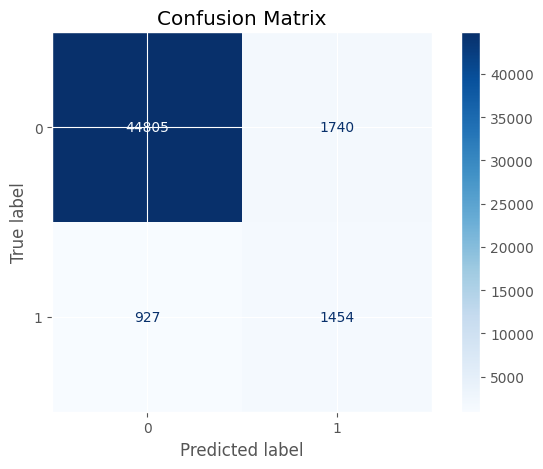

In [204]:
y_probs = model.predict_proba(X_valid)[:, 1]
best_thresh = find_best_threshold(y_valid, y_probs)

y_pred = (y_probs > best_thresh).astype(int)

print(f"\nThreshold: {best_thresh}")
print(classification_report(y_valid, y_pred))
print("ROC AUC:", roc_auc_score(y_valid, y_probs))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

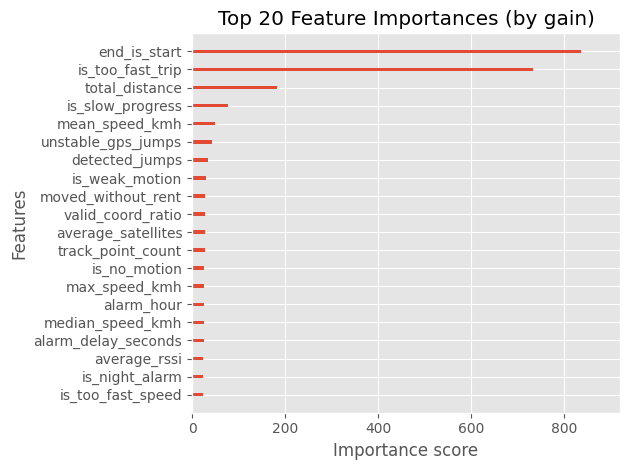

In [205]:
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, importance_type='gain', show_values=False)
plt.title("Top 20 Feature Importances (by gain)")
plt.tight_layout()
plt.show()

## Save model

In [215]:
import pickle

with open("../models/model_xgb_22_04.pkl", "wb") as f:
    pickle.dump(model, f)

feature_list = X_train.columns.tolist()
with open("../data/xgb_features_22_04.txt", "w") as f:
    for feat in feature_list:
        f.write(feat + "\n")

In [ ]:
y_probs = model.predict_proba(X)[:, 1]
incident_ids['prediction'] = y_probs
incident_ids

In [214]:
targets = [0.1 * i for i in range(1, 11)]
for t in targets:
    closest = incident_ids.iloc[(incident_ids['prediction'] - t).abs().argsort()[:2]]
    print(f"\n Ближайшие к {int(t*100)}%:")
    print(closest)


 Ближайшие к 10%:
        incident_id  incident_id  prediction
150248       299704     299704.0    0.100003
84037        233159     233159.0    0.100006

 Ближайшие к 20%:
        incident_id  incident_id  prediction
187276       336816     336816.0    0.200006
36743        185558     185558.0    0.199993

 Ближайшие к 30%:
        incident_id  incident_id  prediction
174865       324373     324373.0    0.299989
131359       280710     280710.0    0.300013

 Ближайшие к 40%:
        incident_id  incident_id  prediction
116128       265403     265403.0    0.399997
224263       373938     373938.0    0.399992

 Ближайшие к 50%:
        incident_id  incident_id  prediction
232481       382179     382179.0    0.500012
135593       284993     284993.0    0.499973

 Ближайшие к 60%:
        incident_id  incident_id  prediction
174813       324321     324321.0    0.599987
166586       316071     316071.0    0.599982

 Ближайшие к 70%:
        incident_id  incident_id  prediction
96063       